In [1]:
%env SM_FRAMEWORK=tf.keras
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import os
os.environ['TF_MIN_GPU_MULTIPROCESSOR_COUNT']='4'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

env: SM_FRAMEWORK=tf.keras
INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1540934545459506749
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9393471488
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14061949564366729641
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:04:00.0, compute capability: 7.5"
]


In [2]:
import warnings
warnings.filterwarnings("ignore")
import os
import gc
import cv2
import json
import time
import random
import numpy as np
import pandas as pd
import tifffile as tiff
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import albumentations as albu
from sklearn.model_selection import train_test_split, KFold, GroupKFold
import tensorflow.keras.backend as K
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import *
import segmentation_models as sm
from segmentation_models import Unet, FPN
from segmentation_models.losses import bce_jaccard_loss
print("tensorflow version:", tf.__version__)
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
if gpu_devices:
    for gpu_device in gpu_devices:
        print("device available:", gpu_device)
policy = tf.keras.mixed_precision.experimental.Policy("mixed_float16")
tf.keras.mixed_precision.experimental.set_policy(policy)
pd.set_option("display.max_columns", None)

Segmentation Models: using `tf.keras` framework.
tensorflow version: 2.6.0-dev20210407
device available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2080 Ti, compute capability 7.5
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


In [3]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 2080 Ti (UUID: GPU-9719cbce-a56b-1f7d-efd5-519baafcfaef)
GPU 1: NVIDIA GeForce RTX 3090 (UUID: GPU-0b211566-f864-21f7-b80e-db06ced5fe0d)


In [4]:
VER = "v08"
PARAMS = {
    "version": VER,
    "folds": 1,
    "img_size": 256,
    "resize": 4,
    "batch_size" : 16,
    "epochs": 100,
    "patience": 20,
    "backbone": "efficientnetb0",# efficientnetbX, resnet34/50, resnext50, seresnet34, seresnext
    "loss": "bce_dice",
    "mirror": False,
    "umodel" : "unet",
    "bce_weight": 1.,
    "shift": True,
    "pseudo":"",
    "lr": 0.0002
}
DATA_PATH = "../input/hubmap-kidney-segmentation"


IMGS_PATH = f"{DATA_PATH}/tiles_r"
MASKS_PATH = f"{DATA_PATH}/masks_r"

MDLS_PATH = f"./models_{VER}"
if not os.path.exists(MDLS_PATH):
    os.mkdir(MDLS_PATH)
with open(f"{MDLS_PATH}/params.json", "w") as file:
    json.dump(PARAMS,file)
        

if not PARAMS["mirror"]:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    STRATEGY = tf.distribute.get_strategy()
else:
    STRATEGY = tf.distribute.MirroredStrategy()

In [5]:
print(PARAMS["pseudo"] == True)

False


In [6]:
df_masks = pd.read_csv(f"{DATA_PATH}/train.csv").set_index("id")


In [7]:
def enc2mask(encs, shape):
    img = np.zeros(shape[0] * shape[1])
    for m, enc in enumerate(encs):
        if isinstance(enc,np.float) and np.isnan(enc): continue
        s = enc.split()
        for i in range(len(s) // 2):
            start = int(s[2 * i]) - 1
            length = int(s[ 2 * i + 1])
            img[start : start + length] = 1 + m
        return img.reshape(shape).T

def show_img_n_mask(df, img_num, resize):
    img = tiff.imread(os.path.join(f'{DATA_PATH}/train', df.index[img_num] + '.tiff'))
    if len(img.shape) == 5:
        img = (np.transpose(img.squeeze(), (1,2,0)))
    mask = enc2mask(df.iloc[img_num], (img.shape[1], img.shape[0]))
    print(img.shape, mask.shape)
    img = cv2.resize(img,
                    (img.shape[1] // reize, img.shape[0] // resize),
                     interpolation = cv2.INTER_NEAREST)
    plt.figure(figsize = (8,8))
    plt.axis("off")
    plt.imshow(img)
    plt.imshow(mask, alpha= 0.4)
    plt.show()



In [8]:
class DataGenKid(Sequence):
    
    def __init__(self, imgs_path, msks_path, imgs_idxs, img_size, batch_size, mode):
        self.imgs_path = imgs_path
        self.msks_path = msks_path
        self.imgs_idxs = imgs_idxs
        self.img_size = img_size
        self.batch_size = batch_size
        self.mode = mode
        
        return None
    
    def __len__(self):
        return int(np.floor(len(self.imgs_idxs) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.imgs_idxs))
    
    def __getitem__(self, index):
        batch_size = min(self.batch_size, len(self.imgs_idxs) - index * self.batch_size)
        X = np.zeros((batch_size, self.img_size, self.img_size, 3), dtype = np.float32)
        imgs_batch = self.imgs_idxs[index * self.batch_size : (index + 1) * self.batch_size]
        if self.mode == "fit":
            y = np.zeros((batch_size, self.img_size, self.img_size), dtype = np.float32)
            for i, img_idx in enumerate(imgs_batch):
                X[i, ], y[i] = self.get_tile(img_idx)
            return X,y
        elif self.mode == "predict":
            for i, img_idx in enumerate(imgs_batch):
                X[i, ] = self.get_tile(img_idx)
            return X
        else:
            raise AttributeError("Fit mode parameter error")
            
    def get_tile(self, img_idx):
        img_path = f"{self.imgs_path}/{img_idx}.png"
        img = cv2.imread(img_path)
        if img is None:
            print(f"error loading image: {image_path}")
        img = img.astype(np.float32) / 255
        if self.mode == "fit":
            msk_path = f"{self.msks_path}/{img_idx}.png"
            msk = cv2.imread(msk_path, cv2.IMREAD_GRAYSCALE)
            if msk is None:
                print(f"error loading mask: {msk_path}")
            return img, msk
        else:
            return img
        

In [9]:
imgs_idxs = [x.replace(".png", "") for x in os.listdir(IMGS_PATH) if "png" in x]
train_datagen = DataGenKid(
        imgs_path = IMGS_PATH,
        msks_path = MASKS_PATH,
        imgs_idxs = imgs_idxs,
        img_size = PARAMS["img_size"],
        batch_size = PARAMS["batch_size"],
        mode = "fit"
)

val_datagen = DataGenKid(
        imgs_path = IMGS_PATH,
        msks_path = MASKS_PATH,
        imgs_idxs = imgs_idxs,
        img_size = PARAMS["img_size"],
        batch_size = PARAMS["batch_size"],
        mode = "fit"
)

In [10]:
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred, smooth = 1):
    return (1 - dice_coef(y_true, y_pred))

def bce_dice_loss(y_true, y_pred):
    return PARAMS["bce_weight"] * binary_crossentropy(y_true, y_pred) + \
        (1 - PARAMS["bce_weight"]) * dice_loss(y_true, y_pred)

def get_model(backbone, input_shape, loss_type = "bce_dice", umodel = "unet", classes = 1, lr = .001):
    with STRATEGY.scope():
        if loss_type == "bce_dice":
            loss = bce_dice_loss
        
        # TODO: Implement other bce_jaccard_loss
            
        else: 
            raise AttributeError("loss mode parameter error")
        
        if umodel == "unet":
            model = Unet(backbone_name = backbone, encoder_weights = "imagenet",
                        input_shape = input_shape, classes = classes, activation = "sigmoid")
            
        elif umodel == "fpn":
            model = FPN(backbone_name = backbone, encoder_weights = "imagemet",
                       input_shape = input_shape,
                       classes = classes, activation = "sigmoid")
        
        else:
            raise AttributeError("umodel mode parameter error")
            
        model.compile(
            optimizer = tfa.optimizers.Lookahead(
                tf.keras.optimizers.Adam(learning_rate = lr),
                sync_period = max(6, int(PARAMS["patience"] / 4))
            ),
            loss = loss,
            metrics = [dice_coef]
        )
        return model

## Train

In [11]:
def train_model(mparams, n_fold, train_datagen, val_datagen):
    model = get_model(
        mparams["backbone"],
        input_shape = (mparams["img_size"], mparams["img_size"], 3),
        loss_type = mparams["loss"],
        umodel = mparams["umodel"],
        lr = mparams["lr"]
    )
    checkpoint_path = f"{MDLS_PATH}/model_{n_fold}.hdf5"
    earlystopper = EarlyStopping (
        monitor = "val_dice_coef",
        patience = mparams["patience"],
        verbose = 0,
        restore_best_weights = True,
        mode = "max"
    )
    lrreducer = ReduceLROnPlateau(
        monitor = "val_dice_coef",
        factor = .1,
        patience = int(mparams["patience"] / 2),
        verbose = 0,
        min_lr = 1e-7,
        mode = "max"
    )
    checkpointer = ModelCheckpoint(
        checkpoint_path,
        monitor = "val_dice_coef",
        verbose = 0,
        save_best_only = True,
        save_weights_only = True,
        mode = "max"
    )
    callbacks = [earlystopper, checkpointer]
    callbacks.append(lrreducer)
    print("lr reduce on plateau")
    history = model.fit(
        train_datagen,
        validation_data = val_datagen,
        callbacks = callbacks,
        epochs = mparams["epochs"],
        verbose = 1
    )
    history_file = f"{MDLS_PATH}/history_{n_fold}.json"
    dict_to_save = {}
    for k,v in history.history.items():
        dict_to_save.update({k: [np.format_float_positional(x) for x in history.history[k]]})
    with open(history_file, "w") as file:
        json.dump(dict_to_save, file)
    model.load_weights(checkpoint_path)
    return model,history
    

In [12]:
model, history = train_model(PARAMS, 1, train_datagen, val_datagen)

  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

lr reduce on plateau
Epoch 1/100
1251/1251 [==============================] - 290s 209ms/step - loss: 0.5531 - dice_coef: 0.0897 - val_loss: 0.4101 - val_dice_coef: 0.1179
Epoch 2/100
1251/1251 [==============================] - 256s 204ms/step - loss: 0.4302 - dice_coef: 0.1163 - val_loss: 0.3933 - val_dice_coef: 0.1177
Epoch 3/100
1251/1251 [==============================] - 253s 203ms/step - loss: 0.4185 - dice_coef: 0.1170 - val_loss: 0.3864 - val_dice_coef: 0.1156
Epoch 4/100
1251/1251 [==============================] - 254s 203ms/step - loss: 0.4050 - dice_coef: 0.1105 - val_loss: 0.3459 - val_dice_coef: 0.1260
Epoch 5/100
1251/1251 [==============================] - 363s 290ms/step - loss: 0.2832 - dice_coef: 0.1779 - val_loss: 0.1735 - val_dice_coef: 0.0277
Epoch 6/100
1251/1251 [==============================] - 424s 339ms/step - loss: 0.0428 - dice_coef: 0.4465 - val_loss: 0.0227 - val_dice_coef: 0.5840
Epoch 7/100
125

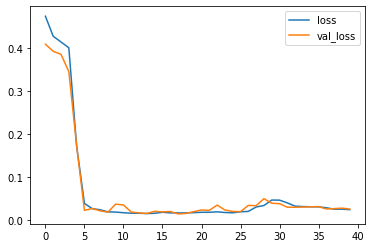

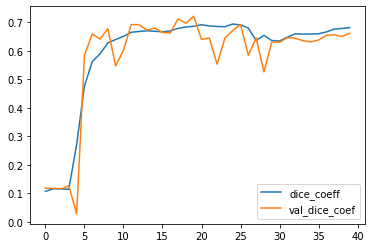


best epoch: 19 

best loss: 0.019594157114624977 

best dice coeff: 0.7208414077758789



In [13]:
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.legend()
plt.show()
plt.plot(history.history["dice_coef"], label = "dice_coeff")
plt.plot(history.history["val_dice_coef"], label = "val_dice_coef")
plt.legend()
plt.show()
best_epoch = np.argmax(history.history["val_dice_coef"])
best_loss = history.history["val_loss"][best_epoch]
best_dice_coef = history.history["val_dice_coef"] [best_epoch]
print(f"""
best epoch: {best_epoch} \n
best loss: {best_loss} \n
best dice coeff: {best_dice_coef}
""")

In [14]:
result = PARAMS.copy()
result["best_epoch"] = np.mean([best_epoch])
result["best_loss"] = np.mean([best_loss])
result["best_dice_coef"] = np.mean([best_dice_coef])
with open(f'{MDLS_PATH}/params.json', "w") as file:
    json.dump(result,file)
if not os.path.exists("results.csv"):
    df_save = pd.DataFrame(result, index = [0])
    df_save.to_csv("results.csv", sep= "\t")
else:
    df_old = pd.read_csv("results.csv", sep = "\t")
    df_save = pd.DataFrame(result, index= [df_old.index.max() + 1])
    df_save = df_old.append(df_save, ignore_index = True)
    df_save.to_csv("results.csv", sep = "\t")

In [15]:
pd.read_csv("results.csv", sep = "\t", index_col=0)

,Unnamed: 0.1,version,folds,img_size,resize,batch_size,epochs,patience,backbone,loss,mirror,umodel,bce_weight,shift,pseudo,lr,best_epoch,best_loss,best_dice_coef
0,0.0,v05,6,256,4,20,2,20,efficientnetb2,bce_dice,False,unet,1.0,True,NaN,0.0002,1.0,0.022014,0.630520
1,NaN,v08,1,256,4,16,100,20,efficientnetb0,bce_dice,False,unet,1.0,True,NaN,0.0002,19.0,0.019594,0.720841


## Predict

In [16]:
n_fold = 1
larger = 4
test_models = []
checkpoint_path = f"{MDLS_PATH}/model_{n_fold}.hdf5"
print(checkpoint_path)
model_lrg = get_model (
    PARAMS["backbone"],
    input_shape = (PARAMS["img_size"] * larger, PARAMS["img_size"] * larger, 3),
    loss_type = PARAMS["loss"],
    umodel = PARAMS["umodel"]
)
model_lrg.load_weights(checkpoint_path) # or .set_weights(model.get_weights()) from smaller model
test_models.append(model_lrg)

./models_v08/model_1.hdf5
  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



In [17]:
img_num = 0
resize = PARAMS["resize"]
shft = 0.6
wnd = PARAMS["img_size"] * larger
img = tiff.imread(os.path.join(f"{DATA_PATH}/train", df_masks.index[img_num] + ".tiff"))
if len(img.shape) == 5: img = np.transpose(img.squeeze(), (1,2,0))
mask = enc2mask(df_masks.iloc[img_num], (img.shape[1], img.shape[0]))
print(img.shape, mask.shape)
imgs = cv2.resize(img,
                 (img.shape[1] // resize, img.shape[0] // resize)
                 )


(31278, 25794, 3) (31278, 25794)
